In [2]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

from typing import List
import logging
import copy
import os
import sys
import gc
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
#This notebook is partly adapted from Saravia et al.'s Emotion dataset notebook which is
#available at this link: https://colab.research.google.com/drive/1nwCE6b9PXIKhv2hvbqf1oZKIGkXMTi1X#scrollTo=t23zHggkEpc-

#In fact, we use the Emotion dataset by Saravia et al. for the first finetuning step. Full citation below.

In [4]:

_CITATION = """\
@inproceedings{saravia-etal-2018-carer,
    title = "{CARER}: Contextualized Affect Representations for Emotion Recognition",
    author = "Saravia, Elvis  and
      Liu, Hsien-Chi Toby  and
      Huang, Yen-Hao  and
      Wu, Junlin  and
      Chen, Yi-Shin",
    booktitle = "Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing",
    month = oct # "-" # nov,
    year = "2018",
    address = "Brussels, Belgium",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/D18-1404",
    doi = "10.18653/v1/D18-1404",
    pages = "3687--3697"
}
"""

## Fine tune on CARER dataset

In [5]:
#we define the paths for train, val, test, same split as already obtained in the T5 notebook
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

In [6]:
#create a dictionary associating each string label to an integer value

labels = [ "sadness", "joy", "anger", "fear"]
label2int = dict(zip(labels, list(range(len(labels)))))

## Building our classifier

In [7]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
#load actual model
model = AutoModelWithLMHead.from_pretrained('roberta-base')
base_model = model.base_model

c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\auto\modeling_auto.py:998: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [8]:
#using Mish activation function 
#(from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py)
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [9]:
#note: the following code is partly adapted from Marcin Zablocki's tutorial 'custom classifier on top of bert-like language model'
#define an EmoClassificationModel class to do the actual fine-tuning

class EmoClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

In [10]:
#load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.json',
 'tokenizer\\merges.txt',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

In [11]:
#implementation of CollateFN to do tokenization and batches of sequences

class TokenizersCollateFn:
    def __init__(self, max_tokens=512): 

        #RoBERTa uses the BPE tokenizer, similarly to GPT-2
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [12]:
#class to create dataset objects from the data

class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [13]:
#we use PyTorch Lighning for training. Lightning methods are defined here

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, len(labels)) #was "distilroberta-base"
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        # self.save_hyperparameters(hparams)
        self.hparams = hparams

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
   
    def save_model(self):
        torch.save(self.model.state_dict(), 'emotion_model/RoBERTa_emotion_2ft.pt')

In [13]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=15,
    warmup_steps=100,
    epochs=10,
    lr=2E-05,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [14]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [15]:
from pytorch_lightning.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # monitor validation loss
    min_delta=0.001, #to very small change in the monitored quantity to qualify as an improvement
    patience=20, # used to check number of time with no improvement after which training will be stopped
    verbose=False, 
    mode="min" #sed while training will stopped when the quantity monitor has stopped decreasing
    )

## Fine tune model

In [16]:
#train (using cuda)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=50,
                     accumulate_grad_batches=hparams.accumulate_grad_batches,
                     early_stop_callback=early_stop_callback)

trainer.fit(module)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `

Epoch 10:  96%|█████████▌| 1150/1201 [01:47<00:04, 10.68it/s, loss=0.018, train_loss=0.018, v_num=157]  


1

In [21]:
#save model (uncomment to save)

# module.save_model()

In [18]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

-
________________________________________________________________________________
              precision    recall  f1-score   support

     sadness     0.9916    0.9344    0.9621       503
         joy     0.9941    0.9864    0.9903       515
       anger     0.9384    0.9767    0.9572       515
        fear     0.9478    0.9722    0.9598       467

    accuracy                         0.9675      2000
   macro avg     0.9680    0.9674    0.9673      2000
weighted avg     0.9683    0.9675    0.9676      2000



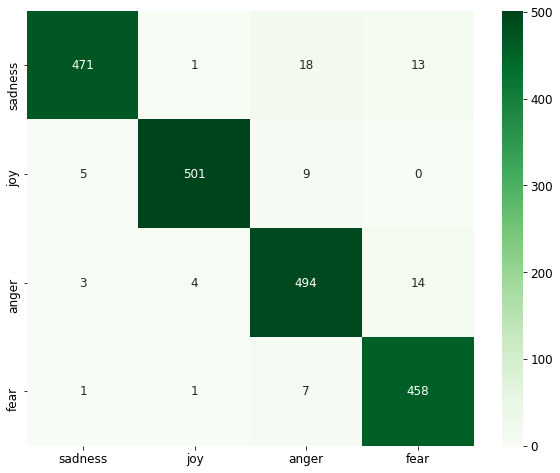

In [16]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');

## Fine tune on EmpatheticPersonas data

In [14]:
#we define the paths for train, val, test
train_path = "emotion_data/my_train.txt"
test_path = "emotion_data/my_test.txt"
val_path = "emotion_data/my_val.txt"

In [17]:
#we use PyTorch Lighning for training. Lightning methods are defined here

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-base").base_model, len(labels)) #was "distilroberta-base"
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        self.hparams = hparams

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW 
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def save_model(self):
        torch.save(self.model.state_dict(), 'emotion_model/RoBERTa_emotion_2ft_2.pt')

In [18]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=15,
    warmup_steps=100,
    epochs=20,
    lr=2E-05,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [19]:
device = torch.device('cuda:0')
module.model.load_state_dict(torch.load('emotion_model/RoBERTa_emotion_2ft.pt'))
module.to(device)

TrainingModule(
  (model): EmoClassificationModel(
    (base_model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_feat

In [27]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [28]:
from pytorch_lightning.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # monitor validation loss
    min_delta=0.001, #to very small change in the monitored quantity to qualify as an improvement
    patience=20, # used to check number of time with no improvement after which training will be stopped
    verbose=False, 
    mode="min" #sed while training will stopped when the quantity monitor has stopped decreasing
    )

In [29]:
#train
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches,
                     early_stop_callback=early_stop_callback)

trainer.fit(module)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `

Epoch 13:  85%|████████▍ | 60/71 [00:04<00:00, 12.07it/s, loss=0.036, train_loss=0.00421, v_num=161]


1

In [ ]:
#save model (uncomment to save)

# module.save_model()


## Evaluation on the EmpatheticPersonas test set

In [30]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

|
________________________________________________________________________________
              precision    recall  f1-score   support

     sadness     0.8846    0.8846    0.8846        26
         joy     0.9697    0.9697    0.9697        33
       anger     0.9714    0.9714    0.9714        35
        fear     0.9200    0.9200    0.9200        25

    accuracy                         0.9412       119
   macro avg     0.9364    0.9364    0.9364       119
weighted avg     0.9412    0.9412    0.9412       119



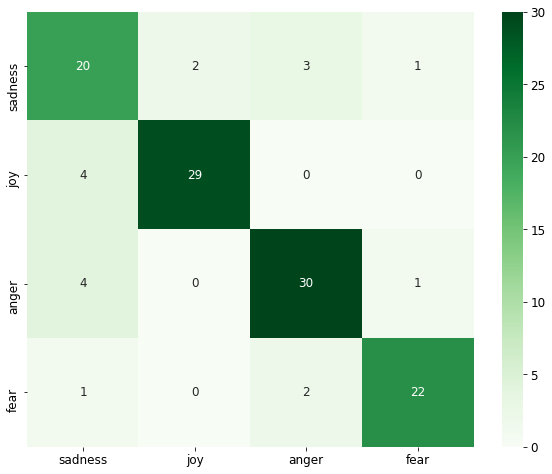

In [19]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');